In [150]:
import numpy as np
from numpy import mean,std

import pandas as pd

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model,Model
from keras.backend import placeholder
import h5py
from zipfile import ZipFile

The Y label ranges from 0- 9 and are already encoded as one-hot matrix.

In [151]:
TrainDataset = h5py.File('train_handsignals.h5','r')
TestDataset = h5py.File('test_handsignals.h5','r')


In [152]:
X_train = np.array(TrainDataset['train_set_x'][:])
X_test = np.array(TestDataset['test_set_x'][:])

Y_train = np.array(TrainDataset['train_set_y'][:])
Y_test = np.array(TestDataset['test_set_y'][:])

2


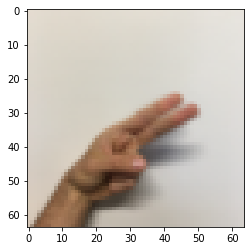

In [153]:
#sample image check
idx = 2
plt.imshow(X_train[idx])
print(Y_train[idx])

In [154]:
m = X_train.shape[0]
pix = X_train.shape[1]
nC = X_train.shape[3]
numLabels = len(np.unique(Y_train))

In [161]:
def data_reshape(X1,X2,Y1,Y2,nC,numLabels):
    
    
    pix = X1.shape[1]
    
    X1 = X1.reshape(-1,pix,pix,nC)
    X2 = X2.reshape(-1,pix,pix,nC)
    

    Y1 = Y1.reshape(-1,1)
    Y2 = Y2.reshape(-1,1)
    
    Y1_oh = to_categorical(Y1,numLabels)
    Y2_oh = to_categorical(Y2,numLabels)
    
    X1_norm = (X1/255.0).astype('float32')
    X2_norm = (X2/255.0).astype('float32')
    
    return Y1_oh,Y2_oh,X1_norm,X2_norm
    
    
    
    
Y_train_oh,Y_test_oh,X_train_norm,X_test_norm = data_reshape(X_train,X_test,Y_train,Y_test,nC,numLabels);    


In [162]:
def Model_Conv2D(X1,X2,Y1,Y2,nC,numLabels):
    
    # reshape the datasets as per our requirements
    
    Y1_oh,Y2_oh,X1_norm,X2_norm = data_reshape(X1,X2,Y1,Y2,nC,numLabels)   
    
    pix = X1.shape[1]
    
    (nX,nY,nC) = X1_norm.shape[1:]
    
    X_input = Input((nX,nY,nC))
    
    
    X = Conv2D(32,(3,3),padding = 'valid',strides = (1,1),activation = 'relu',kernel_initializer = 'he_uniform',bias_initializer = 'zeros',input_shape = (nX,nY,nC))(X_input)
    
    

    X = MaxPooling2D(pool_size = (2,2),strides = None,padding = 'valid')(X)
    
    X = Conv2D(64,(3,3),padding = 'valid',strides = (1,1),activation = 'relu',kernel_initializer = 'he_uniform',bias_initializer = 'zeros')(X)
    
    X = MaxPooling2D(pool_size = (2,2),strides = None,padding = 'valid')(X)
    
    X = Conv2D(64,(3,3),padding = 'valid',strides = (1,1),activation = 'relu',kernel_initializer = 'he_uniform',bias_initializer = 'zeros')(X)
    
    X = MaxPooling2D(pool_size = (2,2),strides = None,padding = 'valid')(X)
    
    X = Flatten()(X)
    
    X = Dense(100,activation = 'relu',use_bias = True,kernel_initializer = 'he_uniform')(X)
    
    X = Dense(80,activation = 'relu',use_bias = True,kernel_initializer = 'he_uniform')(X)

    X =Dense(6,activation = 'softmax')(X)
    
    
    
    #compile the model
    
    model = Model(inputs = X_input,outputs = X)
    
    opt = SGD(learning_rate = 0.01,momentum = 0.9)
    
    model.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])
    
    
    return Y1_oh,Y2_oh,X1_norm,X2_norm,model

    

Epoch 1/20
1080/1080 [==============================] - 4s 4ms/step - loss: 1.8154 - accuracy: 0.1824
Epoch 2/20
1080/1080 [==============================] - 4s 3ms/step - loss: 1.7439 - accuracy: 0.2602
Epoch 3/20
1080/1080 [==============================] - 4s 3ms/step - loss: 1.4878 - accuracy: 0.3889
Epoch 4/20
1080/1080 [==============================] - 4s 3ms/step - loss: 1.0914 - accuracy: 0.5870
Epoch 5/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.9343 - accuracy: 0.6185
Epoch 6/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.7259 - accuracy: 0.7120
Epoch 7/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.4859 - accuracy: 0.8185
Epoch 8/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.4324 - accuracy: 0.8296
Epoch 9/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.3174 - accuracy: 0.8907
Epoch 10/20
1080/1080 [==============================] - 4s 3ms/step - loss: 0.274

Text(0, 0.5, 'loss')

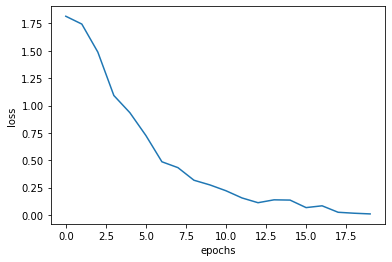

In [183]:
Y_train_oh,Y_test_oh,X_train_norm,X_test_norm,model = Model_Conv2D(X_train,X_test,Y_train,Y_test,nC,numLabels)
history = model.fit(X_train_norm,Y_train_oh,epochs = 20,batch_size = 32)
model.save('final_model.h5')
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [184]:
    
_,test_accuracy = model.evaluate(X_test_norm,Y_test_oh)
print('Test Accuracy :',(100*test_accuracy))
predictions = model.predict(X_test_norm);
pred = [round(x[0]) for x in predictions]     

120/120 [==============================] - 1s 5ms/step
Test Accuracy : 94.16666626930237


In [190]:
def load_image(image_file,pix):
    
    img = load_img(image_file,target_size = ((pix,pix)))
    img = img_to_array(img)
    img = img.reshape(1,pix,pix,3)
    img = img.astype('float32')
    img = img/255.0
    
    return img


In [191]:
img = load_image('image6.jpg',pix)
model = load_model('final_model.h5')
#digit = model.predict_classes(img)  # for sequential models
digit = np.argmax(model.predict(img))  #for model based models
print(digit)


2
